In [ ]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import os
import joblib
import tarfile
import numpy as np

In [ ]:
session = boto3.session.Session()
region = session.region_name
print("AWS Region:", region)

role = get_execution_role()
print("AWS Default Role:", role)

AWS Region: us-west-2
AWS Default Role: arn:aws:iam::691879165105:role/CCL-SageMaker-Role


In [ ]:
# s3://2124323strokepred/ml-project/data/
bucket = '2124323strokepred'
prefix = 'ml-project'

model_prefix = f'{prefix}/model'
data_prefix = f'{prefix}/data'
train_prefix = f'{prefix}/data/train'
test_prefix = f'{prefix}/data/test'
baseline_prefix = f'{prefix}/data/baseline'

In [ ]:
model_dir = f's3://{bucket}/{model_prefix}'
data_dir = f's3://{bucket}/{train_prefix}'

train_file = 'train.csv'
test_file = 'test.csv'
baseline_file = 'baseline.csv'  # Optional

print("S3 Model Directory:", model_dir)
print("S3 Data Directory:", data_dir)

S3 Model Directory: s3://2124323strokepred/ml-project/model
S3 Data Directory: s3://2124323strokepred/ml-project/data/train


In [ ]:
# Test S3 access
s3 = session.client('s3')

try:
    response = s3.list_objects_v2(Bucket=bucket)
    print("S3 Access Test Passed. Bucket 2124323strokepred Contents:")
    for obj in response.get('Contents', []):
        print(obj['Key'])
except Exception as e:
    print("S3 Access Failed:", e)

S3 Access Test Passed. Bucket 2124323strokepred Contents:
ml-project/
ml-project/data/
ml-project/data/Data.csv


In [ ]:
df = pd.read_csv(f's3://{bucket}/{prefix}/data/Data.csv')
print("Data Loaded! Shape:", df.shape)
df.head()

Data Loaded! Shape: (5110, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
local_data_dir = './data'
local_data_file = f'{local_data_dir}/Data.csv'

In [ ]:
df = pd.read_csv('Data.csv')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.shape

(5110, 11)

In [ ]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
print(type(X), X.shape, type(y), y.shape)

<class 'pandas.core.frame.DataFrame'> (5110, 10) <class 'pandas.core.series.Series'> (5110,)


In [ ]:
type(X)

pandas.core.frame.DataFrame

In [ ]:
data = pd.read_csv('Data.csv')

# Define numerical and categorical columns
numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Handle missing values for numerical columns
imputer = SimpleImputer(strategy="mean")
data[numerical_features] = imputer.fit_transform(data[numerical_features])

# One-hot encoding for categorical features
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

In [ ]:
data.shape

(5110, 17)

In [ ]:
data.isnull().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
gender_Male                       0
gender_Other                      0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   gender_Male                     5110 non-null   bool   
 7   gender_Other                    5110 non-null   bool   
 8   ever_married_Yes                5110 non-null   bool   
 9   work_type_Never_worked          5110 non-null   bool   
 10  work_type_Private               5110 non-null   bool   
 11  work_type_Self-employed         5110 non-null   bool   
 12  work_type_children              51

In [ ]:
data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,True,False,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,28.893237,1,False,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.500000,1,True,False,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.400000,1,False,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.000000,1,False,False,True,False,False,True,False,False,False,True,False


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
X = data.drop(columns='stroke')  # Features
y = data['stroke']

In [ ]:
X = np.array(X)

In [ ]:
y = np.array(y)

In [ ]:
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
# Convert the datatype to float32 (to run Linear Learner successfully)
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
print(type(X_train),type(X_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
import io
import numpy as np
import sagemaker.amazon.common as smac

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0)

0

In [ ]:
# optional
buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0)

0

In [ ]:
import os

# Key refers to the name of the file
key = 'linear-train-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://2124323strokepred/ml-project/train/linear-train-data


In [ ]:
# Define S3 key for test data
key = "linear-test-data"

# Upload the file to S3
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)

# Print test data location in S3
s3_test_data = f"s3://{bucket}/{prefix}/test/{key}"
print(f"Uploaded test data location: {s3_test_data}")

Uploaded test data location: s3://2124323strokepred/ml-project/test/linear-test-data


In [ ]:
try:
    response = s3.list_objects_v2(Bucket=bucket)
    print("S3 Access Test Passed. Bucket 2124323strokepred Contents:")
    for obj in response.get('Contents', []):
        print(obj['Key'])
except Exception as e:
    print("S3 Access Failed:", e)

S3 Access Test Passed. Bucket 2124323strokepred Contents:
ml-project/
ml-project/data-capture/strokepred-endpoint/AllTraffic/2025/05/27/11/08-56-740-420af3da-c8d9-49a5-833e-a23214d09d1f.jsonl
ml-project/data/
ml-project/data/Data.csv
ml-project/output/linear-learner-2025-05-27-10-28-33-393/debug-output/training_job_end.ts
ml-project/output/linear-learner-2025-05-27-10-28-33-393/output/model.tar.gz
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/framework/training_job_end.ts
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/system/incremental/2025052710/1748341740.algo-1.json
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/system/incremental/2025052710/1748341800.algo-1.json
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/system/incremental/2025052710/1748341860.algo-1.json
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/system/training_job_end.ts
ml-project/test/li

In [ ]:
# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://2124323strokepred/ml-project/output


In [ ]:
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [ ]:
# We have pass in the container, the type of instance that we would like to use for training
# output path and sagemaker session into the Estimator.
# We can also specify how many instances we would like to use for training
sagemaker_session = sagemaker.Session()
linear = sagemaker.estimator.Estimator(container,
                                       role,
                                       instance_count = 1,
                                       instance_type = 'ml.m5.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)


# We can tune parameters like the number of features that we are passing in, type of predictor like 'regressor' or 'classifier', mini batch size, epochs
# Train 32 different versions of the model and will get the best out of them (built-in parameters optimization!)

linear.set_hyperparameters(feature_dim = 16,
                           predictor_type = 'binary_classifier',
                           mini_batch_size = 10,
                           epochs = 10,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model
linear.fit({'train': s3_train_data})

# Let's see the progress using cloudwatch logs

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: linear-learner-2025-05-27-10-28-33-393


2025-05-27 10:28:34 Starting - Starting the training job...
2025-05-27 10:29:07 Downloading - Downloading input data...
2025-05-27 10:29:27 Downloading - Downloading the training image......
2025-05-27 10:30:33 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/27/2025 10:30:43 INFO 139748077274944] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '0.01

In [ ]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sagemaker.model_monitor import DataCaptureConfig

data_capture_loc = data_dir = f's3://{bucket}/{prefix}/data-capture/'

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=data_capture_loc,
    capture_options=["REQUEST", "RESPONSE"]
)

linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m5.xlarge',
                                 endpoint_name='strokepred-endpoint',
                                 data_capture_config=data_capture_config,
                                 serializer=CSVSerializer(),
                                 deserializer=JSONDeserializer())

INFO:sagemaker:Creating model with name: linear-learner-2025-05-27-11-01-39-079
INFO:sagemaker:Creating endpoint-config with name strokepred-endpoint
INFO:sagemaker:Creating endpoint with name strokepred-endpoint


---------!

In [ ]:
result = linear_regressor.predict(X_test)

In [ ]:
result

{'predictions': [{'score': 0.0004868395917583257, 'predicted_label': 0},
  {'score': -4.6375003876164556e-05, 'predicted_label': 0},
  {'score': 0.00013204343849793077, 'predicted_label': 0},
  {'score': 0.00033118511782959104, 'predicted_label': 0},
  {'score': 0.0007769989315420389, 'predicted_label': 0},
  {'score': 0.00011909601744264364, 'predicted_label': 0},
  {'score': 0.00018098042346537113, 'predicted_label': 0},
  {'score': 0.0003882539749611169, 'predicted_label': 0},
  {'score': 0.0002558404812589288, 'predicted_label': 0},
  {'score': 0.00043604339589364827, 'predicted_label': 0},
  {'score': 0.00038365472573786974, 'predicted_label': 0},
  {'score': 0.00031693922937847674, 'predicted_label': 0},
  {'score': 0.00014047874719835818, 'predicted_label': 0},
  {'score': 0.0006317979423329234, 'predicted_label': 0},
  {'score': 0.00031334636150859296, 'predicted_label': 0},
  {'score': -7.577301585115492e-05, 'predicted_label': 0},
  {'score': 0.0014947656309232116, 'predicted

In [ ]:
predictions = np.array([r['score'] for r in result['predictions']])

In [ ]:
predictions

array([ 4.86839592e-04, -4.63750039e-05,  1.32043438e-04, ...,
        7.80140050e-04,  1.39067916e-03, -1.42420555e-04])

In [ ]:
predictions.shape

(1533,)

In [ ]:
y_test.shape

(1533,)

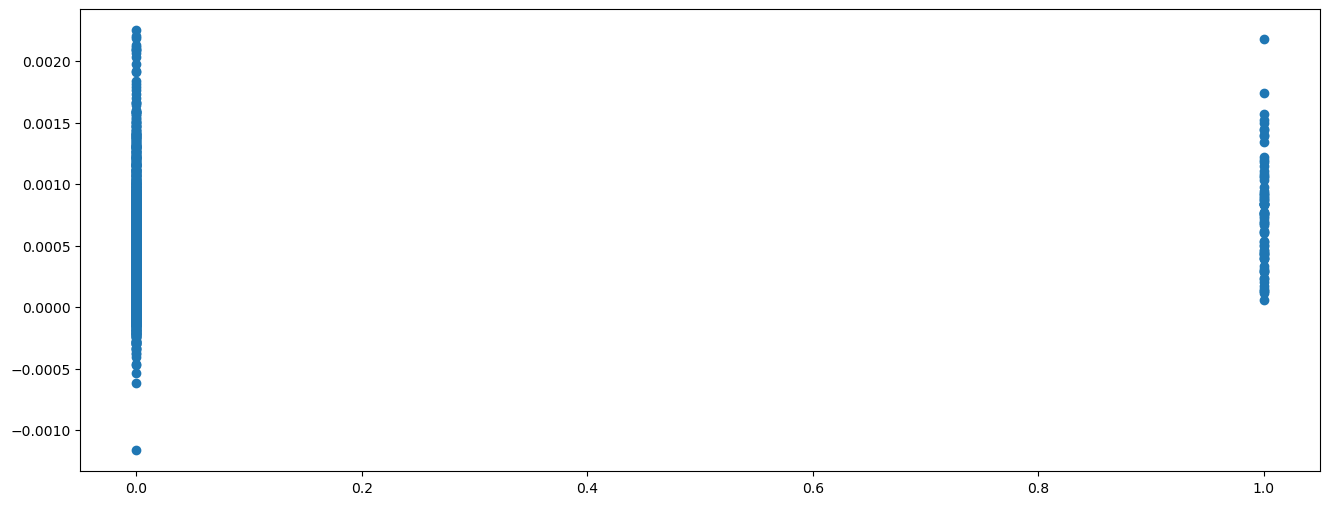

In [ ]:
# Visualize how accurate predictions are relative to y_test
import matplotlib.pyplot as plt
plt.figure(figsize = (16, 6))
plt.scatter(y_test, predictions)

In [ ]:
# data capture analysis
try:
    response = s3.list_objects_v2(Bucket=bucket)
    print("S3 Access Test Passed. Bucket 2124323strokepred Contents:")
    for obj in response.get('Contents', []):
        print(obj['Key'])
except Exception as e:
    print("S3 Access Failed:", e)

S3 Access Test Passed. Bucket 2124323strokepred Contents:
ml-project/
ml-project/data-capture/strokepred-endpoint/AllTraffic/2025/05/27/11/08-56-740-420af3da-c8d9-49a5-833e-a23214d09d1f.jsonl
ml-project/data/
ml-project/data/Data.csv
ml-project/output/linear-learner-2025-05-27-10-28-33-393/debug-output/training_job_end.ts
ml-project/output/linear-learner-2025-05-27-10-28-33-393/output/model.tar.gz
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/framework/training_job_end.ts
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/system/incremental/2025052710/1748341740.algo-1.json
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/system/incremental/2025052710/1748341800.algo-1.json
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/system/incremental/2025052710/1748341860.algo-1.json
ml-project/output/linear-learner-2025-05-27-10-28-33-393/profiler-output/system/training_job_end.ts
ml-project/test/li

In [ ]:
captured_file_key = 'ml-project/data-capture/strokepred-endpoint/AllTraffic/2025/05/27/11/08-56-740-420af3da-c8d9-49a5-833e-a23214d09d1f.jsonl'
local_file = 'captured_data.jsonl'

s3.download_file(bucket, captured_file_key, local_file)


with open(local_file, 'r') as f:
    lines = f.readlines()
    print(f"Total captured records: {len(lines)}")

Total captured records: 1


In [ ]:
from sagemaker.workflow.pipeline_context import PipelineSession
pipeline_session = PipelineSession()

In [ ]:
from sagemaker.model import Model
from sagemaker.workflow.model_step import ModelStep

model = Model(
    image_uri='174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:1',
    model_data='https://2124323strokepred.s3.us-west-2.amazonaws.com/ml-project/output/linear-learner-2025-05-27-10-28-33-393/output/model.tar.gz',
    sagemaker_session=pipeline_session,
    role=role
)
